In [13]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg')


### Create the data


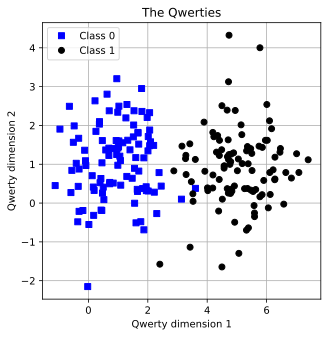

In [20]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# ক্লাস্টার সংখ্যা ও blur
nPerClust = 100
blur = 1

# দুইটি ক্লাস্টারের কেন্দ্র
A = [1, 1]
B = [5, 1]

# ডেটা তৈরি
a = [A[0] + np.random.randn(nPerClust) * blur, A[1] + np.random.randn(nPerClust) * blur]
b = [B[0] + np.random.randn(nPerClust) * blur, B[1] + np.random.randn(nPerClust) * blur]

# লেবেল
labels_np = np.vstack((np.zeros((nPerClust, 1)), np.ones((nPerClust, 1))))

# ডেটা একত্র করে (200 x 2 shape)
data_np = np.hstack((a, b)).T

# PyTorch tensor-এ রূপান্তর
data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).float()

# ভিজুয়ালাইজেশন
fig = plt.figure(figsize=(5, 5))
plt.plot(data[np.where(labels == 0)[0], 0], data[np.where(labels == 0)[0], 1], 'bs', label='Class 0')
plt.plot(data[np.where(labels == 1)[0], 0], data[np.where(labels == 1)[0], 1], 'ko', label='Class 1')
plt.title('The Qwerties')
plt.xlabel('Qwerty dimension 1')
plt.ylabel('Qwerty dimension 2')
plt.legend()
plt.grid(True)
plt.show()


### Function to build and train the model

In [21]:
import torch
import torch.nn as nn

def createANNmodel(learningrate):
    # 🔸 Model Architecture:
    # Input: 2D feature → Hidden: 1 → Output: 1 (binary classification)
    ANNclassify = nn.Sequential(
        nn.Linear(2, 1),     # 2 input → 1 hidden
        nn.ReLU(),           # Activation (not needed here for final layer)
        nn.Linear(1, 1)      # Hidden → Output
    )

    # 🔸 Binary classification loss with raw logits
    lossfun = nn.BCEWithLogitsLoss()

    # 🔸 Optimizer: Stochastic Gradient Descent
    optimizer = torch.optim.SGD(ANNclassify.parameters(), lr=learningrate)

    return ANNclassify, lossfun, optimizer


In [24]:
def trainTheModel(ANNmodel, data, labels, lossfun, optimizer, numepochs=1000):
    # Initialize losses
    losses = torch.zeros(numepochs)

    for epochi in range(numepochs):
        # Forward propagation
        yHat = ANNmodel(data)

        # Compute the loss
        loss = lossfun(yHat, labels)
        losses[epochi] = loss.item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Final prediction after training
    predictions = ANNmodel(data)
    
    #  Apply Sigmoid before thresholding (because using BCEWithLogitsLoss)
    pred_labels = torch.sigmoid(predictions) > 0.5
    
    # Accuracy calculation
    totalacc = 100 * torch.mean((pred_labels == labels).float())

    return losses, predictions, totalacc


### Test the new code by running it once

Final accuracy: 98%


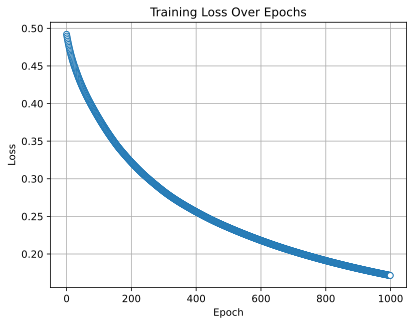

In [29]:
# Create everything
ANNclassify, lossfun, optimizer = createANNmodel(.01)

# Train the model with required arguments
losses, predictions, totalacc = trainTheModel(ANNclassify, data, labels, lossfun, optimizer)

# Report accuracy
print('Final accuracy: %g%%' % totalacc)

# Plot the loss over epochs
plt.plot(losses.detach(), 'o', markerfacecolor='w', linewidth=.1)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.grid(True)
plt.show()


### nOW FOR THE EXPERIMENTS

In [32]:
import numpy as np

# Learning rates নির্ধারণ (0.001 থেকে 0.1, মোট 40টি মান)
learningrates = np.linspace(.001, .1, 40)

# Epoch সংখ্যা
numepochs = 1000  # Ensure you defined this earlier or pass to trainTheModel

# ফলাফল রাখার জন্য জায়গা তৈরি
accByLR = []  # প্রতিটি learning rate এর জন্য accuracy
allLosses = np.zeros((len(learningrates), numepochs))  # প্রতিটি lr এর জন্য loss curve

# প্রতিটি learning rate এর জন্য মডেল ট্রেন করুন
for i, lr in enumerate(learningrates):
    # মডেল তৈরি
    ANNclassify, lossfun, optimizer = createANNmodel(lr)
    
    # ট্রেন করা
    losses, predictions, totalacc = trainTheModel(ANNclassify, data, labels, lossfun, optimizer, numepochs)
    
    # ফলাফল সংরক্ষণ
    accByLR.append(totalacc)
    allLosses[i, :] = losses.detach()  # detach to avoid computational graph


C:\Users\roger\AppData\Local\Temp\ipykernel_14216\2340582158.py:23: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  allLosses[i, :] = losses.detach()  # detach to avoid computational graph


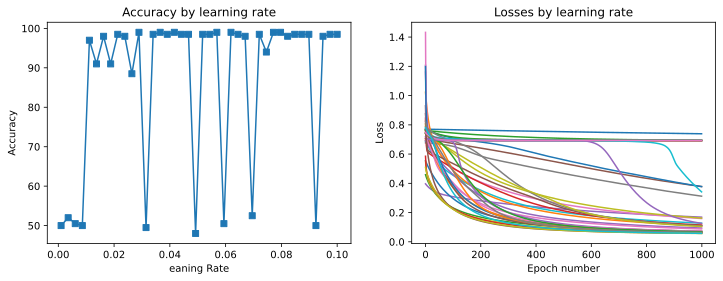

In [34]:
##plot the results
fig,ax=plt.subplots(1,2,figsize=(12,4))

ax[0].plot(learningrates,accByLR,'s-')
ax[0].set_xlabel('eaning Rate')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Accuracy by learning rate')

ax[1].plot(allLosses.T)
ax[1].set_xlabel('Epoch number')
ax[1].set_ylabel('Loss')
ax[1].set_title('Losses by learning rate')
plt.show()

In [35]:
##proportion of runs where the model had at least 70% accuracy
sum(torch.tensor(accByLR)>70)/len(accByLR)

tensor(0.7750)

### Run a meta-experiment to get more reliable results

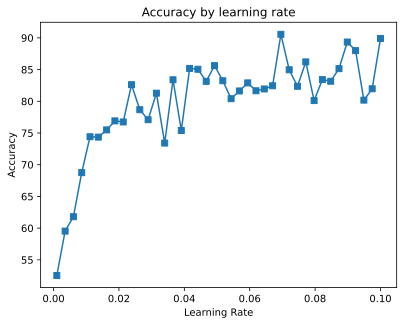

In [36]:
numExps=50

##matrix to store all results
accMeta=np.zeros((numExps,len(learningrates)))

numepochs=500
for expi in range(numExps):
    for i,lr in enumerate(learningrates):
        ANNclassify,lossfun,optimizer=createANNmodel(lr)
        losses,predictions,totalacc=trainTheModel(ANNclassify, data, labels, lossfun, optimizer, numepochs)

        accMeta[expi,i]=totalacc

plt.plot(learningrates,np.mean(accMeta,axis=0),'s-')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.title('Accuracy by learning rate')
plt.show()